In [1]:
!pip install datasets --quiet
!pip install transformers[torch] --quiet
!pip install accelerate -U --quiet
!pip install matplotlib --quiet

In [2]:
!pip install evaluate --quiet

In [3]:
# Function to convert excel file to csv
import pandas as pd

def convert_excel_to_csv(excel_file, csv_file):
    try:
        # Read Excel file
        df = pd.read_excel(excel_file)

        # Write DataFrame to CSV
        df.to_csv(csv_file, index=False)

        print(f"Conversion successful! Excel file '{excel_file}' converted to CSV file '{csv_file}'.")
    except Exception as e:
        print(f"Error converting Excel to CSV: {e}")

# Example usage
excel_file = "train.xlsx"
csv_file = "train.csv"
convert_excel_to_csv(excel_file, csv_file)

Conversion successful! Excel file 'train.xlsx' converted to CSV file 'train.csv'.


In [4]:
from datasets import load_dataset
ds = load_dataset('csv', data_files = "train.csv")

# Rename column to match columns for original model
ds = ds.rename_column("News Headline", "text")
ds = ds.rename_column("Sentiment", "label")

Generating train split: 0 examples [00:00, ? examples/s]

In [5]:
df = pd.read_csv("train.csv")

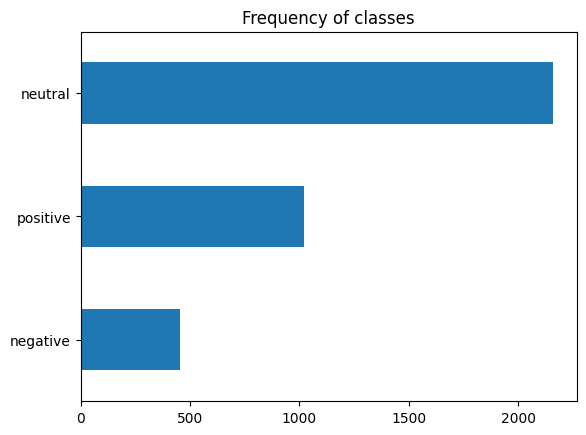

In [6]:
import matplotlib.pyplot as plt
df["Sentiment"].value_counts(ascending=True).plot.barh()
plt.title("Frequency of classes")
plt.show()

In [7]:
type(ds["train"][100])

dict

In [8]:
def label_to_int(example):
    # Replace "label" with the actual name of your label column
    label = example["label"]
    # Define your label-to-integer mapping logic here
    label_dict = {"neutral": 0, "positive": 1, "negative": 2}  # Example mapping
    return {"label": label_dict[label]}

ds = ds.map(label_to_int)

Map:   0%|          | 0/3636 [00:00<?, ? examples/s]

In [ ]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("distilroberta-base")

In [10]:
# Function to Tokenize the dataset
def tokenize_function(examples):
  return tokenizer(examples["text"], padding="max_length", truncation=True)

tokenized_datasets = ds.map(tokenize_function, batched=True)

Map:   0%|          | 0/3636 [00:00<?, ? examples/s]

In [13]:
train_dataset = tokenized_datasets["train"].select(range(2000))
eval_dataset = tokenized_datasets["train"].select(range(2000,3200))

In [14]:
from transformers import AutoModelForSequenceClassification

model = AutoModelForSequenceClassification.from_pretrained("mrm8488/distilroberta-finetuned-financial-news-sentiment-analysis", num_labels=3)

In [15]:
from transformers import TrainingArguments

training_args = TrainingArguments(output_dir="test_trainer")

In [16]:
import numpy as np
import evaluate

metric = evaluate.load("accuracy")
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return metric.compute(predictions=predictions, references=labels)

In [17]:
from transformers import TrainingArguments, Trainer

training_args = TrainingArguments(output_dir="test_trainer",
                                  evaluation_strategy="epoch",
                                  )

In [18]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    compute_metrics=compute_metrics,
)

In [19]:
tokenized_datasets

DatasetDict({
    train: Dataset({
        features: ['label', 'text', 'input_ids', 'attention_mask'],
        num_rows: 3636
    })
})

In [20]:
print(trainer.model.config)

RobertaConfig {
  "_name_or_path": "mrm8488/distilroberta-finetuned-financial-news-sentiment-analysis",
  "architectures": [
    "RobertaForSequenceClassification"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "negative",
    "1": "neutral",
    "2": "positive"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "negative": 0,
    "neutral": 1,
    "positive": 2
  },
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 514,
  "model_type": "roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 6,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "problem_type": "single_label_classification",
  "torch_dtype": "float32",
  "transformers_version": "4.35.2",
  "type_vocab_size": 1,
  "use_cache": true,
  "vocab_size": 50265
}



In [21]:
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy
1,No log,0.494016,0.842500
2,0.518500,0.500047,0.857500
3,0.518500,0.613510,0.864167


TrainOutput(global_step=750, training_loss=0.40828802998860675, metrics={'train_runtime': 333.6932, 'train_samples_per_second': 17.981, 'train_steps_per_second': 2.248, 'total_flos': 794818566144000.0, 'train_loss': 0.40828802998860675, 'epoch': 3.0})